In [14]:
# This code is supporting material for the book
# Building Machine Learning Systems with Python
# by Willi Richert and Luis Pedro Coelho
# published by PACKT Publishing
#
# It is made available under the MIT License

%pylab inline

import time
start_time = time.time()

import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.cross_validation import KFold
from sklearn import neighbors

from data import chosen, chosen_meta
from utils import plot_pr
from utils import plot_feat_importance
from utils import load_meta
from utils import fetch_posts
from utils import plot_feat_hist
from utils import plot_bias_variance
from utils import plot_k_complexity

# question Id -> {'features'->feature vector, 'answers'->[answer Ids]}, 'scores'->[scores]}
# scores will be added on-the-fly as the are not in meta
meta, id_to_idx, idx_to_id = load_meta(chosen_meta)

import nltk

# The sorting below is only to ensure reproducable numbers. Further down
# we will occasionally skip a fold when it contains instances of only
# one label. The two lines below ensure that the behavior is exactly the
# same for different runs.

Populating the interactive namespace from numpy and matplotlib


In [15]:
all_questions = sorted([q for q, v in meta.items() if v['ParentId'] == -1])
all_answers = sorted([q for q, v in meta.items() if v['ParentId'] != -1])

In [16]:
feature_names = np.array((
    'NumTextTokens',
    'NumCodeLines',
    'LinkCount',
    'AvgSentLen',
    'AvgWordLen',
    'NumAllCaps',
    'NumExclams',
    'NumImages'
))

In [17]:
def prepare_sent_features():
    for pid, text in fetch_posts(chosen, with_index=True):
        if not text:
            meta[pid]['AvgSentLen'] = meta[pid]['AvgWordLen'] = 0
        else:
            from platform import python_version
            if python_version().startswith('2'):
                text = text.decode('utf-8')
            sent_lens = [len(nltk.word_tokenize(
                sent)) for sent in nltk.sent_tokenize(text)]
            meta[pid]['AvgSentLen'] = np.mean(sent_lens)
            meta[pid]['AvgWordLen'] = np.mean(
                [len(w) for w in nltk.word_tokenize(text)])

        meta[pid]['NumAllCaps'] = np.sum(
            [word.isupper() for word in nltk.word_tokenize(text)])

        meta[pid]['NumExclams'] = text.count('!')


prepare_sent_features()

In [18]:
def get_features(aid):
    return tuple(meta[aid][fn] for fn in feature_names)

/Users/sungchulchoi/miniconda3/envs/python_ml_env/lib/python3.4/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/sungchulchoi/miniconda3/envs/python_ml_env/lib/python3.4/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


ValueError: operands could not be broadcast together with shapes (10,) (11,) (10,) 

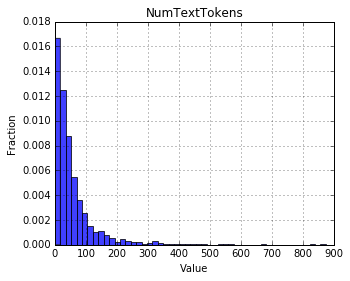

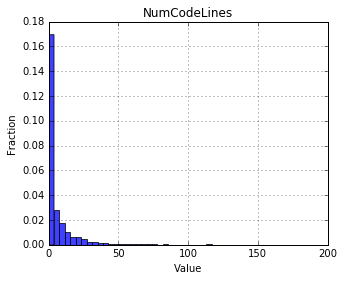

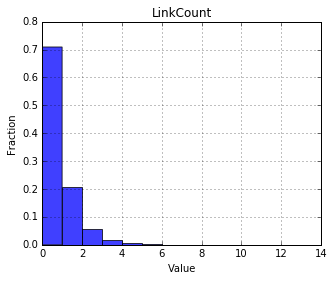

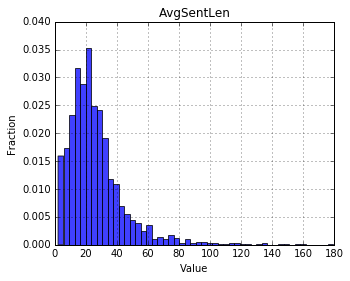

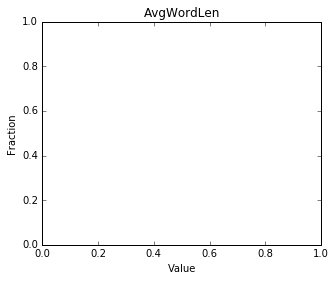

In [19]:
qa_X = np.asarray([get_features(aid) for aid in all_answers])

classifying_answer = "good"
#classifying_answer = "poor"

if classifying_answer == "good":
    # Score > 0 tests => positive class is good answer
    qa_Y = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])
elif classifying_answer == "poor":
    # Score <= 0 tests => positive class is poor answer
    qa_Y = np.asarray([meta[aid]['Score'] <= 0 for aid in all_answers])
else:
    raise Exception("classifying_answer='%s' is not supported" %
                    classifying_answer)

for idx, feat in enumerate(feature_names):
    plot_feat_hist([(qa_X[:, idx], feat)])

#plot_feat_hist([(qa_X[:, idx], feature_names[idx]) for idx in [1,0]], 'feat_hist_two.png')
#plot_feat_hist([(qa_X[:, idx], feature_names[idx]) for idx in [3,4,5,6]], 'feat_hist_four.png')

In [27]:
avg_scores_summary = []


def measure(clf_class, parameters, name, data_size=None, plot=False):
    start_time_clf = time.time()
    if data_size is None:
        X = qa_X
        Y = qa_Y
    else:
        X = qa_X[:data_size]
        Y = qa_Y[:data_size]

    cv = KFold(n=len(X), n_folds=10)

    train_errors = []
    test_errors = []

    scores = []
    roc_scores = []
    fprs, tprs = [], []

    pr_scores = []
    precisions, recalls, thresholds = [], [], []

    for fold_idx, (train, test) in enumerate(cv):
        X_train, y_train = X[train], Y[train]
        X_test, y_test = X[test], Y[test]

        only_one_class_in_train = len(set(y_train)) == 1
        only_one_class_in_test = len(set(y_test)) == 1
        if only_one_class_in_train or only_one_class_in_test:
            # this would pose problems later on
            continue

        clf = clf_class(**parameters)

        clf.fit(X_train, y_train)

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)

        train_errors.append(1 - train_score)
        test_errors.append(1 - test_score)

        scores.append(test_score)
        proba = clf.predict_proba(X_test)

        label_idx = 1
        fpr, tpr, roc_thresholds = roc_curve(y_test, proba[:, label_idx])
        precision, recall, pr_thresholds = precision_recall_curve(
            y_test, proba[:, label_idx])

        roc_scores.append(auc(fpr, tpr))
        fprs.append(fpr)
        tprs.append(tpr)

        pr_scores.append(auc(recall, precision))
        precisions.append(precision)
        recalls.append(recall)
        thresholds.append(pr_thresholds)

        # This threshold is determined at the end of the chapter 5,
        # where we find conditions such that precision is in the area of
        # about 80%. With it we trade off recall for precision.
        threshold_for_detecting_good_answers = 0.59

        print("Clone #%i" % fold_idx)
        print(classification_report(y_test, proba[:, label_idx] >
              threshold_for_detecting_good_answers, target_names=['not accepted', 'accepted']))

    # get medium clone
    scores_to_sort = pr_scores  # roc_scores
    medium = np.argsort(scores_to_sort)[len(scores_to_sort) / 2]
    print("Medium clone is #%i" % medium)

    if plot:
        #plot_roc(roc_scores[medium], name, fprs[medium], tprs[medium])
        plot_pr(pr_scores[medium], name, precisions[medium],
                recalls[medium], classifying_answer + " answers")

        if hasattr(clf, 'coef_'):
            plot_feat_importance(feature_names, clf, name)

    summary = (name,
               np.mean(scores), np.std(scores),
               np.mean(roc_scores), np.std(roc_scores),
               np.mean(pr_scores), np.std(pr_scores),
               time.time() - start_time_clf)
    print(summary)
    avg_scores_summary.append(summary)
    precisions = precisions[medium]
    recalls = recalls[medium]
    thresholds = np.hstack(([0], thresholds[medium]))
    idx80 = precisions >= 0.8
    print("P=%.2f R=%.2f thresh=%.2f" % (precisions[idx80][0], recalls[
          idx80][0], thresholds[idx80][0]))

    return np.mean(train_errors), np.mean(test_errors)

In [28]:
def bias_variance_analysis(clf_class, parameters, name):
    #import ipdb;ipdb.set_trace()
    data_sizes = np.arange(60, 2000, 4)

    train_errors = []
    test_errors = []

    for data_size in data_sizes:
        train_error, test_error = measure(
            clf_class, parameters, name, data_size=data_size)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_bias_variance(data_sizes, train_errors,
                       test_errors, name, "Bias-Variance for '%s'" % name)

In [29]:
def k_complexity_analysis(clf_class, parameters):
    ks = np.hstack((np.arange(1, 20), np.arange(21, 100, 5)))

    train_errors = []
    test_errors = []

    for k in ks:
        parameters['n_neighbors'] = k
        train_error, test_error = measure(
            clf_class, parameters, "%dNN" % k, data_size=2000)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_k_complexity(ks, train_errors, test_errors)

In [ ]:
for k in [5]:
# for k in [5, 10, 40]:
    #measure(neighbors.KNeighborsClassifier, {'n_neighbors': k}, "%iNN" % k)
    bias_variance_analysis(neighbors.KNeighborsClassifier, {
                           'n_neighbors': k}, "%iNN" % k)
    k_complexity_analysis(neighbors.KNeighborsClassifier, {'n_neighbors': k})

Clone #0
              precision    recall  f1-score   support

not accepted       0.25      0.50      0.33         2
    accepted       0.50      0.25      0.33         4

 avg / total       0.42      0.33      0.33         6

Clone #1
              precision    recall  f1-score   support

not accepted       0.17      1.00      0.29         1
    accepted       0.00      0.00      0.00         5

 avg / total       0.03      0.17      0.05         6

Clone #2
              precision    recall  f1-score   support

not accepted       0.67      0.67      0.67         3
    accepted       0.67      0.67      0.67         3

 avg / total       0.67      0.67      0.67         6

Clone #3
              precision    recall  f1-score   support

not accepted       0.50      0.25      0.33         4
    accepted       0.25      0.50      0.33         2

 avg / total       0.42      0.33      0.33         6

Clone #4
              precision    recall  f1-score   support

not accepted       0.67 

/Users/sungchulchoi/miniconda3/envs/python_ml_env/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sungchulchoi/miniconda3/envs/python_ml_env/lib/python3.4/site-packages/ipykernel/__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Clone #3
              precision    recall  f1-score   support

not accepted       0.50      0.40      0.44         5
    accepted       0.40      0.50      0.44         4

 avg / total       0.46      0.44      0.44         9

Clone #4
              precision    recall  f1-score   support

not accepted       0.50      0.50      0.50         4
    accepted       0.60      0.60      0.60         5

 avg / total       0.56      0.56      0.56         9

Clone #5
              precision    recall  f1-score   support

not accepted       0.75      1.00      0.86         3
    accepted       1.00      0.83      0.91         6

 avg / total       0.92      0.89      0.89         9

Clone #6
              precision    recall  f1-score   support

not accepted       0.57      1.00      0.73         4
    accepted       1.00      0.40      0.57         5

 avg / total       0.81      0.67      0.64         9

Clone #7
              precision    recall  f1-score   support

not accepted       0.80 

Clone #0
              precision    recall  f1-score   support

not accepted       0.50      1.00      0.67         2
    accepted       1.00      0.50      0.67         4

 avg / total       0.83      0.67      0.67         6

Clone #1
              precision    recall  f1-score   support

not accepted       0.50      1.00      0.67         1
    accepted       1.00      0.80      0.89         5

 avg / total       0.92      0.83      0.85         6

Clone #2
              precision    recall  f1-score   support

not accepted       0.75      1.00      0.86         3
    accepted       1.00      0.67      0.80         3

 avg / total       0.88      0.83      0.83         6

Clone #3
              precision    recall  f1-score   support

not accepted       1.00      0.50      0.67         4
    accepted       0.50      1.00      0.67         2

 avg / total       0.83      0.67      0.67         6

Clone #4
              precision    recall  f1-score   support

not accepted       0.75 

/Users/sungchulchoi/miniconda3/envs/python_ml_env/lib/python3.4/site-packages/ipykernel/__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Clone #7
              precision    recall  f1-score   support

not accepted       0.67      0.80      0.73         5
    accepted       0.80      0.67      0.73         6

 avg / total       0.74      0.73      0.73        11

Clone #8
              precision    recall  f1-score   support

not accepted       0.60      0.75      0.67         4
    accepted       0.80      0.67      0.73         6

 avg / total       0.72      0.70      0.70        10

Clone #9
              precision    recall  f1-score   support

not accepted       0.67      0.80      0.73         5
    accepted       0.75      0.60      0.67         5

 avg / total       0.71      0.70      0.70        10

Medium clone is #7
('LogReg C=0.10', 0.6836363636363636, 0.13970452881671669, 0.77002380952380967, 0.14955968821890495, 0.84637480459355463, 0.10335936880981804, 0.017715930938720703)
P=0.80 R=0.67 thresh=0.51
Clone #0
              precision    recall  f1-score   support

not accepted       0.38      1.00      0.5

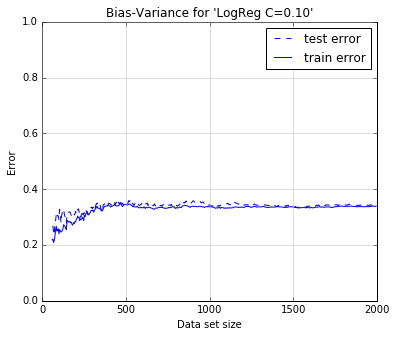

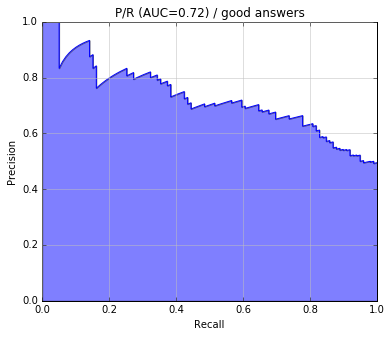

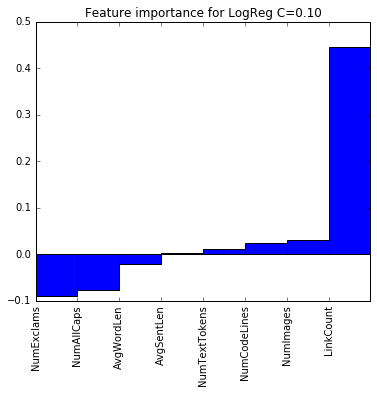

In [31]:
from sklearn.linear_model import LogisticRegression
for C in [0.1]:
# for C in [0.01, 0.1, 1.0, 10.0]:
    name = "LogReg C=%.2f" % C
    bias_variance_analysis(LogisticRegression, {'penalty': 'l2', 'C': C}, name)
    measure(LogisticRegression, {'penalty': 'l2', 'C': C}, name, plot=True)

print("=" * 50)
from operator import itemgetter
for s in reversed(sorted(avg_scores_summary, key=itemgetter(1))):
    print("%-20s\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f" % s)

print("time spent:", time.time() - start_time)